In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('amazon_baby_subset.csv')
with open('important_words.json','r') as f:
    imp_words = json.load(f)

In [3]:
data.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


### remove punctuation

In [4]:
def remove_punctuation(text):
    text = str(text)
    import string
    return text.translate( text.maketrans('','',string.punctuation) ) 

In [5]:
data['review_clean']=data['review'].apply(remove_punctuation)

In [6]:
data.head()

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...


### Word count using imp words

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
data.isna().astype(int).sum()

name             90
review          241
rating            0
sentiment         0
review_clean      0
dtype: int64

In [11]:
data.fillna({'review':''},inplace=True)

In [12]:
data.isna().astype(int).sum()

name            90
review           0
rating           0
sentiment        0
review_clean     0
dtype: int64

In [13]:
for word in imp_words:
    data[word]=data['review_clean'].apply(lambda s: s.split().count(word) )

### index for train and test in json

In [18]:
with open("module-4-assignment-train-idx.json",'r') as f:
    train_idx = json.load(f)

In [20]:
with open("module-4-assignment-validation-idx.json",'r') as f:
    test_idx = json.load(f)

In [22]:
train = data.iloc[train_idx,:]
val = data.iloc[test_idx,:]

### train and val into multi dim arrays

In [23]:
def get_numpy_data(df, feat, label):
    df['constant'] = 1
    feat = ['constant'] + feat
    
    feat_mat = df[feat]
    feat_mat = feat_mat.as_matrix()
    
    label_arr = df[label]
    label_arr = label_arr.as_matrix()
    
    return feat_mat,label_arr

In [26]:
feat_mat_train, sent_train = get_numpy_data(train, imp_words, 'sentiment')
feat_mat_val, sent_val = get_numpy_data(val, imp_words, 'sentiment') 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


## gradient ascent with L2 regularisation

In [27]:
## produces probablistic estimate for P(y_i = +1 | x_i, w).

def predict_probability(feat_mat, wts):
    score =np.dot(feat_mat,wts)
    prob = 1/(1+np.exp(-score))
    
    return prob

In [28]:
def feature_derivative_with_L2(error, feat, wt , l2_pen, feature_is_constant): 
    
    derivative = np.dot( feat,error )

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        derivative = derivative - 2 * l2_pen * wt
        
    return derivative

In [45]:
def compute_log_likelihood_with_L2(feat_mat, sent, wts, l2_pen ):
    indicator = (sent==+1)
    scores = np.dot(feat_mat, wts)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_pen * np.sum(wts[1:]**2)
    
    return lp

In [51]:
def logistic_regression_with_L2(feat_mat, sent, init_wts, step, l2_pen, max_iter):
    
    wts = np.array(init_wts) 
    
    for itr in range(max_iter):
        
        prob = predict_probability(feat_mat,wts)
        
        indicator = (sent==+1)
        
        errors = indicator - prob
        
        for j in range(len(wts)): # loop over each coefficient
            
            is_intercept = (j == 0)
            derivative = feature_derivative_with_L2(errors,feat_mat[:,j],wts[j],l2_pen,is_intercept)
            
            wts[j] = wts[j] + step*derivative
        
        if (itr <= 100 and itr % 50 == 0) or (itr <= 1000 and itr % 200 == 0) or (itr <= 10000 and itr % 2000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feat_mat, sent, wts, l2_pen)
            print('iteration %*d: log likelihood of observed labels = %.8f' % (int(np.ceil(np.log10(max_iter))), itr, lp) )
    return wts

In [90]:
feat_mat = feat_mat_train 
sent = sent_train 
init_wts = np.zeros((194,))
step = 5e-6
max_iter = 501
l2_pen = [0, 4, 10, 1e2, 1e3, 1e5]

In [91]:
df = pd.DataFrame(index=imp_words,columns=l2_pen)

In [92]:
coef = []
for l2 in l2_pen:
    wts = logistic_regression_with_L2(feat_mat,sent,init_wts,step,l2,max_iter)
    df[l2]=wts[1:]

iteration   0: log likelihood of observed labels = -29179.39138303
iteration  50: log likelihood of observed labels = -24509.63590026
iteration 100: log likelihood of observed labels = -22794.90974921
iteration 200: log likelihood of observed labels = -21283.29527353
iteration 400: log likelihood of observed labels = -20152.21466944
iteration   0: log likelihood of observed labels = -29179.39508175
iteration  50: log likelihood of observed labels = -24517.52091982
iteration 100: log likelihood of observed labels = -22813.44844580
iteration 200: log likelihood of observed labels = -21321.14164794
iteration 400: log likelihood of observed labels = -20219.92048845
iteration   0: log likelihood of observed labels = -29179.40062984
iteration  50: log likelihood of observed labels = -24529.31188025
iteration 100: log likelihood of observed labels = -22841.08995135
iteration 200: log likelihood of observed labels = -21377.25595328
iteration 400: log likelihood of observed labels = -20319.2568

In [93]:
df.head()

,0.0,4.0,10.0,100.0,1000.0,100000.0
baby,0.074073,0.073994,0.073877,0.072360,0.059752,0.001784
one,0.012753,0.012495,0.012115,0.007247,-0.008761,-0.001827
great,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950
love,1.058554,1.050856,1.039529,0.896644,0.418354,0.009042
use,-0.000104,0.000163,0.000556,0.005481,0.017326,0.000418


In [114]:
df.sort_values(by=0.0,ascending=False,inplace=True)
df.head()

,0.0,4.0,10.0,100.0,1000.0,100000.0
love,1.058554,1.050856,1.039529,0.896644,0.418354,0.009042
loves,1.052484,1.043903,1.031265,0.870794,0.345870,0.006150
easy,0.984559,0.977600,0.967362,0.838245,0.401904,0.008808
perfect,0.835693,0.828555,0.818038,0.684143,0.250614,0.003989
great,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950


In [115]:
df.tail()

,0.0,4.0,10.0,100.0,1000.0,100000.0
returned,-0.572707,-0.567518,-0.559870,-0.462056,-0.150021,-0.002225
waste,-0.617809,-0.612475,-0.604620,-0.505189,-0.190631,-0.003345
return,-0.742085,-0.735502,-0.725807,-0.602646,-0.215199,-0.003730
money,-0.768793,-0.762734,-0.753818,-0.641406,-0.275883,-0.005487
disappointed,-0.955437,-0.946980,-0.934518,-0.775625,-0.266095,-0.004013


### 5 most pos and neg in l2_pen = 0

In [120]:
ind = df.index
pos = list(ind[:5])
neg = list(ind[-5:])

In [121]:
print(pos)
print(neg)

['love', 'loves', 'easy', 'perfect', 'great']
['returned', 'waste', 'return', 'money', 'disappointed']


In [127]:
l=[]
for word in pos:
    ele = list(df.loc[word])
    l.append(ele)
for word in neg:
    ele = list(df.loc[word])
    l.append(ele)

In [129]:
table = np.array(l)
table.shape

(10, 6)

## Coefficient plot

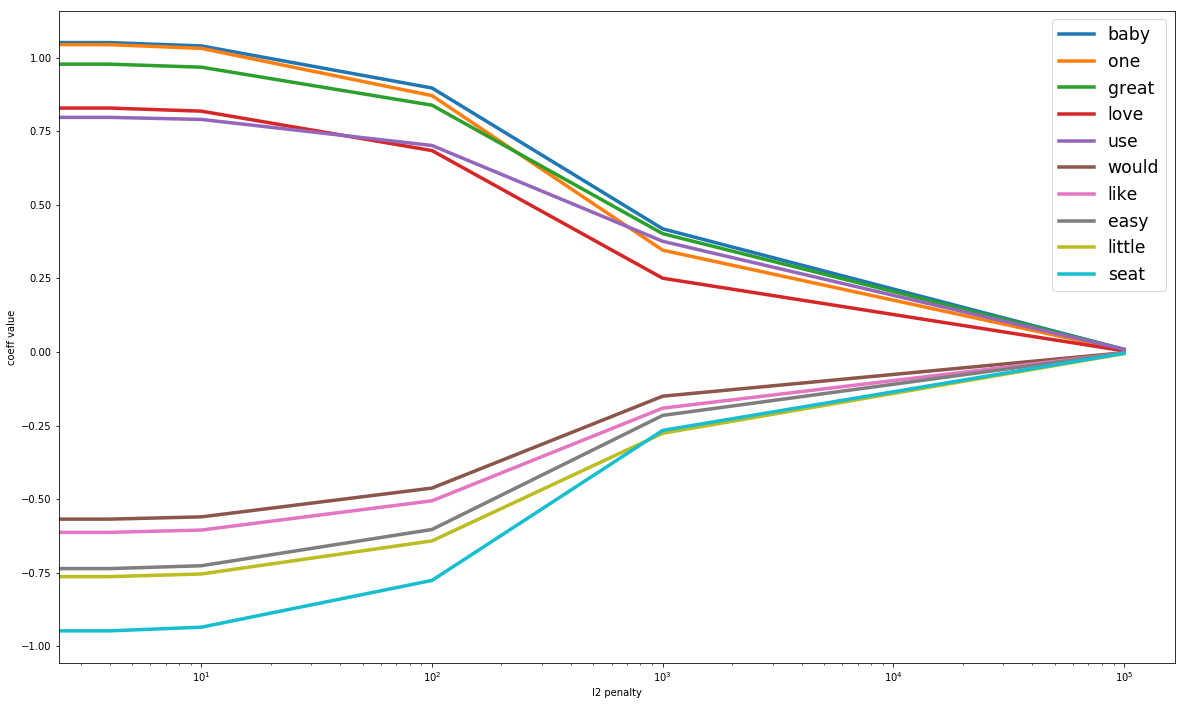

In [163]:
plt.figure(figsize=(20,12))
for i in range(len(table)):
    plt.plot(l2_pen,table[i],label=imp_words[i],linewidth=3.5)
plt.xscale('log')
plt.xlabel('l2 penalty')
plt.ylabel('coeff value')
plt.legend(fontsize='xx-large')
plt.show()

## Accuracy

In [209]:
new = pd.DataFrame(df,index=imp_words)

In [210]:
def sentiment_pred(feat_mat,wts):
    score = np.dot( feat_mat,wts )
    pred=[]
    for i in range(len(score)):
        if(score[i]>0):
            pred.append(+1)
        else:
            pred.append(-1)
    return pred

In [211]:
def accuracy(pred,label_arr):
    ctr=0
    for i in range(len(pred)):
        if(pred[i]==label_arr[i]):
            ctr+=1
    acc = ctr/len(pred)
    return acc

In [213]:
## on train data
acc_list = []

for l2 in l2_pen:
    val=[1] + list(new.loc[:,l2])
    wts = np.array(val)
    pred = sentiment_pred(feat_mat_train,wts)
    acc = accuracy(pred,sent_train)
    acc_list.append(acc)

In [214]:
acc_list

[0.6844503198696915,
 0.6831283491891126,
 0.681900804985718,
 0.66138665281745,
 0.5525129246240645,
 0.5015698401831874]

In [215]:
val = max(acc_list)
acc_list.index(val)

0

In [216]:
## on test data
acc_list = []

for l2 in l2_pen:
    val=[1] + list(new.loc[:,l2])
    wts = np.array(val)
    pred = sentiment_pred(feat_mat_val,wts)
    acc = accuracy(pred,sent_val)
    acc_list.append(acc)

In [217]:
acc_list

[0.6751003641116609,
 0.6739800205396321,
 0.6730464008962749,
 0.6516665110633928,
 0.5498086079731117,
 0.49780599383811036]

In [218]:
val = max(acc_list)
acc_list.index(val)

0